In [1]:
import pickle
import sys
sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')

import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

import h5py
from gglm.glm.base import GLM
from gglm.metrics import bernoulli_log_likelihood_poisson_process
from kernel.values import KernelBasisValues
from signals import auto_covariance
from sptr.sptr import SpikeTrain

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import seaborn as sns
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='tab:blue', ml='#2ca02c', mmd='C1')    

root_folder = '/home/diego/Dropbox/generative_glm/figures/huk/'

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
path = "/home/diego/python/generative-glm/cool_stuff/p110509b_dots_mat_diego.h5"
f = h5py.File(path, "r")

mask_spikes = np.array(np.stack((f['spk']), axis=1), dtype=bool)
dt = 1
t = np.arange(0, mask_spikes.shape[0], 1)
T = t[-1] - t[0] + t[1]

In [4]:
from cycler import cycler

mpl.rcParams['axes.prop_cycle'] = cycler(color=['#CD4545', 'dodgerblue', '#ff7f0e', '#9467bd', 
                                                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

In [5]:
def broken_yaxis(ax1, ax2, d=0.15):
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
#     ax1.xaxis.tick_top()
    ax1.tick_params(axis='x', labeltop=False, labelbottom=False, length=0, width=0)
#     ax1.set_xticks([])
#     ax2.xaxis.tick_bottom()
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
#     kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
#     ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# #     ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

#     kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
#     ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
#     ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    return ax1, ax2

In [6]:
def plot_layout(figsize):
    r1, c1 = 6, 2
    r2, c2 = 3, 1
    r2a, r2b = 1, 2
    nrows, ncols = r1, c1 + 4 * c2
    fig = plt.figure(figsize=figsize)
    axeta = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=nrows, colspan=c1)
    ax00 = plt.subplot2grid((nrows, ncols), (0, c1), rowspan=r2, colspan=c2)
#     ax01 = plt.subplot2grid((nrows, ncols), (0, c1 + c2), rowspan=r2, colspan=c2)
    ax01a = plt.subplot2grid((nrows, ncols), (0, c1 + c2), rowspan=r2a, colspan=c2)
    ax01b = plt.subplot2grid((nrows, ncols), (r2a, c1 + c2), rowspan=r2b, colspan=c2, sharex=ax01a)
    broken_yaxis(ax01a, ax01b)
    ax02 = plt.subplot2grid((nrows, ncols), (0, c1 + 3 * c2), rowspan=r2, colspan=c2)
#     ax03 = plt.subplot2grid((nrows, ncols), (0, c1 + 3 * c2), rowspan=r2, colspan=c2)
    ax03a = plt.subplot2grid((nrows, ncols), (0, c1 + 2 * c2), rowspan=r2a, colspan=c2)
    ax03b = plt.subplot2grid((nrows, ncols), (r2a, c1 + 2 * c2), rowspan=r2b, colspan=c2, sharex=ax03a)
    broken_yaxis(ax03a, ax03b)
    ax10 = plt.subplot2grid((nrows, ncols), (r2, c1), rowspan=r2, colspan=c2, sharey=ax00)
    ax11 = plt.subplot2grid((nrows, ncols), (r2, c1 + c2), rowspan=r2, colspan=c2)
    ax12 = plt.subplot2grid((nrows, ncols), (r2, c1 + 2 * c2), rowspan=r2, colspan=c2)
    ax13 = plt.subplot2grid((nrows, ncols), (r2, c1 + 3 * c2), rowspan=r2, colspan=c2)
    return fig, (axeta, ax00, ax01a, ax01b, ax02, ax03a, ax03b, ax10, ax11, ax12, ax13)

# plot_layout((10, 8))

In [7]:
def observables(model):
    u_dc_train, r_dc_train = model.sample_conditioned(t, mask_spikes_train)
    u_dc_val, r_dc_val = model.sample_conditioned(t, mask_spikes_val)
    u_fr, r_fr, mask_spikes_fr = model.sample(t, shape=(n,))
    
#     print(np.sum(mask_spikes_fr, 0)[np.sum(mask_spikes_fr, 0) > 50])    
#     mask_spikes_fr = mask_spikes_fr[:, np.sum(mask_spikes_fr, 0) < 50]

    st_fr = SpikeTrain(t, mask_spikes_fr)
    isi_fr = st_fr.isi_distribution()
    mu_isi_fr = np.mean(isi_fr)
    sd_isi_fr = np.std(isi_fr)
    
    ll_train = np.sum(np.log(1 - np.exp(-dt * r_dc_train[mask_spikes_train]) + 1e-24) ) - \
                dt * np.sum(r_dc_train[~mask_spikes_train])
    ll_train = (ll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
    ll_val = np.sum(np.log(1 - np.exp(-dt * r_dc_val[mask_spikes_val]) + 1e-24) ) - \
                dt * np.sum(r_dc_val[~mask_spikes_val])
    ll_val = (ll_val - nll_pois_proc_val) / np.log(2) / n_spk_val

    fr = np.sum(mask_spikes_fr, 0) / T * 1000
    mu_fr_fr = np.mean(fr) 
    sd_fr_fr = np.std(fr)
    autocor_fr = np.mean(auto_covariance(mask_spikes_fr, method='fft', subtract_mean=False, 
                                            stationary_signal=False, biased=False), 1)
    autocor_fr = autocor_fr[:250]
    
    autocor_mse = np.mean((autocor_fr - autocor_val)**2)**0.5
    ci_mse = np.mean((np.mean(r_dc_val, 1) - np.mean(r_fr, 1))**2)
    
    return ll_train, ll_val, fr, mu_fr_fr, sd_fr_fr, isi_fr, mu_isi_fr, sd_isi_fr, ci_mse, autocor_mse

In [8]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [9]:
# u_dc_val, r_dc_val = mmdglm.sample_conditioned(t, mask_spikes_val)
# u_fr, r_fr, mask_spikes_fr = mmdglm.sample(t, shape=(n,))
# ci_mse = np.mean((np.mean(r_dc_val, 1) - np.mean(r_fr, 1))**2)

In [10]:
dic_labels = {'mmd_autocov': "$<C_{x}, C_{x'}>$", 'mmd_gaussian': r"$\exp(-(\nu_x - \nu_{x'})^2 / \sigma )$", 
              'cimmd_gaussian': r"$\exp(-\sum(\lambda - \lambda')^2 / \sigma )$",
    'cimmd_means': "$ \mu[\lambda], \mu[\lambda'] $", 'cimmd_autocov': "$ <C_{H_x}, C_{H_{x'}}> $"}

In [11]:
def violinplot(ax, data, position, widths, showmeans, color):
    parts = ax.violinplot(data, positions=[position], widths=widths, showmeans=showmeans, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(1)
    parts['cmeans'].set_color('k')
    parts['cmeans'].set_dashes('--')
    return ax

number outliers 15 out of 400
1 n_batch_fr 100
number outliers 0 out of 400
2 n_batch_fr 400
number outliers 3 out of 400
3 n_batch_fr 400
number outliers 0 out of 400
4 n_batch_fr 100
number outliers 0 out of 400
5 n_batch_fr 100
number outliers 0 out of 400


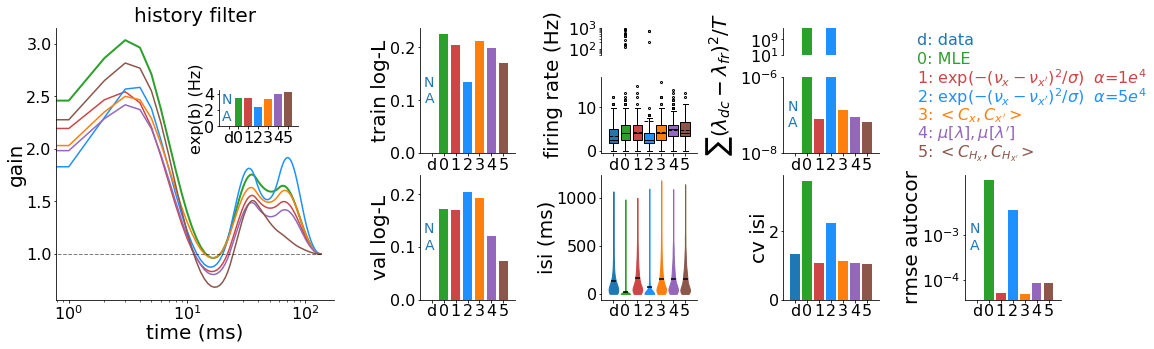

In [17]:
#             'mmd_gaussian_fr_lammmd10000.0biasedTrue_epochs600_lr0.01_2.pk', # almost stable
#             'mmd_gaussian_fr_lammmd20000.0biasedTrue_epochs600_lr0.01_1.pk', # almost stable

pk_files = [ 
            
            # gaussian_fr
            'mmd_gaussian_fr_lammmd10000.0biasedTrue_epochs400_lr0.05_1.pk', # stable
            'mmd_gaussian_fr_lammmd50000.0biasedTrue_epochs600_lr0.01_1.pk', # interistingly stable
    
            # autocov spikes. need more of this
            'mmd_autocov_lammmd10000.0biasedTrue_epochs1000_lr0.002_1.pk',
#             'mmd_gaussian_fr_autocov_lammmd1.0biasedTrue_epochs1000_lr0.01_1.pk', # placeholder for a good one of this
#             'mmd_gaussian_fr_autocov_lammmd1.0biasedTrue_epochs1000_lr0.01_3.pk', 
    
            # mean_CI
            'cimmd_means_product_lammmd5000.0biasedTrue_epochs1000_lr0.01_1.pk', #stable
    
            # gaussian_CI
#             'cimmd_gaussian_lammmd5000.0biasedTrue_epochs400_lr0.01_1.pk', # stable. gives similar results as mean_CI 1st file
    
            # kill the belly in the end
              'cimmd_autocov_lammmd5000.0biasedTrue_epochs300_lr0.01_1.pk', # stableeeee
#             'cimmd_autocov_lammmd500.0biasedTrue_epochs400_lr0.01_1.pk', #unstable
#             'cimmd_autocov_lammmd5000.0biasedTrue_epochs400_lr0.01_1.pk', #unstable
#             'cimmd_autocov_lammmd5000.0biasedTrue_epochs750_lr0.01_3.pk', #unstable
#             'cimmd_autocov_lammmd10000.0biasedTrue_epochs400_lr0.01_2.pk', #unstable
    
            # kill the belly in the beginning
#             'cimmd_autocov_lammmd700.0biasedTrue_epochs500_lr0.01_1.pk' #unstable
#             'cimmd_autocov_lammmd1000.0biasedTrue_epochs600_lr0.01_1.pk' # file lost
    
    #             'mmd_autocov_lammmd100000.0biasedTrue_epochs1000_lr0.002_1.pk',
            ]

# np.random.seed(0)
# n = 1000

# np.random.seed(20)
# n = 400

np.random.seed(30)
n = 400

# fig, (axeta, ax01, ax02, ax03) = plt.subplots(figsize=(15, 5), ncols=4)
# ax00, ax01a, ax01b, ax02, ax03a, ax03b, ax10, ax11, ax12, ax13
fig, (axeta, axll_train, axfra, axfrb, axlabels, axcia, axcib, axll_val, axmuisi, axsdisi, axac) = plot_layout(figsize=(18, 5))
fig.subplots_adjust(hspace=0.8, wspace=0.9)


t_ker = np.arange(0, 137, 1)

axbias = inset_axes(axeta, width=1.1, height=0.5, bbox_to_anchor=(0, 0, .9, .8),
                   bbox_transform=axeta.transAxes)
# myplt.set_labels(axbias, xlabel='', ylabel='exp(b) (Hz)')
axbias.set_ylabel('exp(b) (Hz)', fontsize=tick_labelsize)
axbias.set_yticks([0, 2, 4])
# axbias.set_yticks([0, 5e-3])
# axins1.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=False)
# axbias.tick_params(axis='both', labelsize=12)
# axbias.set_ylim(-5e-3, 1e-2)

widths = 0.8

x0 = -0.5

with open(root_folder + pk_files[0], "rb") as fit_file:
    pk = pickle.load(fit_file)
    offset = 100
    n_train, n_val = pk['n_train'], pk['n_val']
    mask_spikes_train = mask_spikes[:, :offset + n_train]
    n_spk_train = np.sum(mask_spikes_train)
    nll_pois_proc_train = bernoulli_log_likelihood_poisson_process(mask_spikes_train)
#     mask_spikes_val = mask_spikes[:, offset + n_train:offset + n_train + n_val]
    mask_spikes_val = mask_spikes[:, 200:400]
    st_val = SpikeTrain(t, mask_spikes_val)
    isi_val = st_val.isi_distribution()
    n_spk_val = np.sum(mask_spikes_val)
    fr_val = np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000
    mu_fr_val = np.mean(fr_val)
    nll_pois_proc_val = bernoulli_log_likelihood_poisson_process(mask_spikes_val)
    autocor_val = np.mean(auto_covariance(mask_spikes_val, method='fft', subtract_mean=False, 
                                            stationary_signal=False, biased=False), 1)
    autocor_val = autocor_val[:250]
    
    axfra.boxplot(fr_val, positions=[0], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor=palette['d']), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
    axfrb.boxplot(fr_val, positions=[0], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor=palette['d']), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
    violinplot(axmuisi, isi_val, 0, widths=widths, showmeans=True, color=palette['d'])
    axlabels.text(x0, 0.9, 'd: data', transform=axlabels.transAxes, color=palette['d'], fontsize=16, 
                  horizontalalignment='left', verticalalignment='center')
#     parts = axmuisi.violinplot(isi_val, positions=[0], widths=widths, showmeans=True)
#     for pc in parts['bodies']:
#         pc.set_facecolor(palette['d'])
#         pc.set_edgecolor(palette['d'])
#         pc.set_alpha(1)
        
    axsdisi.bar(0, np.std(isi_val) / np.mean(isi_val), color=palette['d'])
    
    eta_ml = KernelBasisValues(pk['basis'], [0, pk['basis'].shape[0]], 1, coefs=pk['eta_coefs_ml'])
    glm_ml = GLM(u0=pk['u0_ml'], eta=eta_ml)
#     ax00.bar(0, glm.u0, color=palette['ml'])
    axbias.bar(1, np.exp(glm_ml.u0) * 1000, color=palette['ml'])
    glm_ml.eta.plot(t=t_ker, ax=axeta, exp_values=True, lw=2, color=palette['ml'])

    ll_train_ml, ll_ml, fr_ml, mu_fr_fr, ci_mse, isi_fr, mu_isi_fr, sd_isi_fr, ci_mse, autocor_mse = observables(glm_ml)
#     u_dc_ml, r_dc_ml = glm_ml.sample_conditioned(t, mask_spikes_val)
#     u_fr_ml, r_fr_ml, mask_spikes_ml = glm_ml.sample(t, shape=(n,))
#     st_fr_ml = SpikeTrain(t, mask_spikes_ml)
#     isi_fr_ml = st_fr_ml.isi_distribution()
#     mean_isi_fr_ml = np.mean()
#     ll_ml= np.sum(np.log(1 - np.exp(-dt * r_dc_ml[mask_spikes_val]) + 1e-24) ) - \
#                 dt * np.sum(r_dc_ml[~mask_spikes_val])
#     ll_ml = (ll_ml - nll_pois_proc_val) / np.log(2) / n_spk_val

#     fr_ml = np.mean(np.sum(mask_spikes_ml, 0) / T) * 1000
    
    axll_train.bar(1, ll_train_ml, color=palette['ml'])
    axll_val.bar(1, ll_ml, color=palette['ml'])
#     axfr.bar(0, mu_fr_fr, color=palette['ml'])
    axfra.boxplot(fr_ml, positions=[1], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor=palette['ml']), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
    axfrb.boxplot(fr_ml, positions=[1], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor=palette['ml']), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
    print('number outliers', np.sum(fr_ml > 100), 'out of', len(fr_ml))
#     axsdfr.bar(0, sd_fr_fr, color=palette['ml'])
#     axmuisi.bar(0, mean_isi_fr_ml, color=palette['ml'])
    violinplot(axmuisi, isi_fr, 1, widths=widths, showmeans=True, color=palette['ml'])
    axsdisi.bar(1, sd_isi_fr / mu_isi_fr, color=palette['ml'])
    axcia.bar(1, ci_mse, color=palette['ml'])
    axcib.bar(1, ci_mse, color=palette['ml'])
    axac.bar(1, autocor_mse, color=palette['ml'])
    axlabels.text(x0, 0.9 - 0.15, '0: MLE', transform=axlabels.transAxes, color=palette['ml'], fontsize=16, 
                  horizontalalignment='left', verticalalignment='center')
        
for ii, pk_f in enumerate(pk_files):
    with open(root_folder + pk_f, "rb") as fit_file:
        pk = pickle.load(fit_file)
        print(ii + 1, 'n_batch_fr', pk['n_batch_fr'])
        eta_mmd = KernelBasisValues(pk['basis'], [0, pk['basis'].shape[0]], 1, coefs=pk['eta_coefs_mmd'])
        mmdglm = GLM(u0=pk['u0_mmd'], eta=eta_mmd)
#         ax00.bar(ii + 1, mmdglm.u0)
        axbias.bar(ii + 2, np.exp(mmdglm.u0) * 1000)
        mmdglm.eta.plot(t=t_ker, exp_values=True, ax=axeta)
        
#         ll_val, fr_fr, mean_isi_fr, var_isi_fr = observables(mmdglm)
        ll_train, ll_val, fr, mu_fr_fr, sd_fr_fr, isi_fr, mu_isi_fr, sd_isi_fr, ci_mse, autocor_mse = observables(mmdglm)
        print('number outliers', np.sum(fr > 100), 'out of', len(fr))
        
        axll_train.bar(ii + 2, ll_train)
        axll_val.bar(ii + 2, ll_val)
#         axfr.bar(ii + 1, mu_fr_fr)
#         sns.boxplot(x=np.zeros(len(fr)) + ii + 1, y=fr, ax=axfr)
        axfra.boxplot(fr, positions=[ii + 2], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor='C' + str(ii)), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
        axfrb.boxplot(fr, positions=[ii + 2], patch_artist=True, widths=widths,showmeans=True, meanline=True, 
                          boxprops=dict(facecolor='C' + str(ii)), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
#         axsdfr.bar(ii + 1, sd_fr_fr)
        violinplot(axmuisi, isi_fr, ii + 2, widths=widths, showmeans=True, color='C' + str(ii))
#         axmuisi.bar(ii + 1, mu_isi_fr)
        axsdisi.bar(ii + 2, sd_isi_fr / mu_isi_fr)
        axcia.bar(ii + 2, ci_mse)
        axcib.bar(ii + 2, ci_mse)
        axac.bar(ii + 2, autocor_mse)
        label = '_'.join(pk_f.split('_')[:2])
#         axlabels.text(0.1, 0.9 - 0.1 * ii, "$\lambda \lambda'$", transform=axsdfr.transAxes)
        if ii == 0:
            axlabels.text(x0, 0.9 - 0.15 * (ii + 2), str(ii + 1) + ': ' + dic_labels[label] + r'  $\alpha$=' \
                          + '$1e^4$', transform=axlabels.transAxes, 
                      color='C' + str(ii), fontsize=16, horizontalalignment='left', verticalalignment='center')
        elif ii == 1:
            axlabels.text(x0, 0.9 - 0.15 * (ii + 2), str(ii + 1) + ': ' + dic_labels[label] + r'  $\alpha$=' \
                          + '$5e^4$', transform=axlabels.transAxes, 
                      color='C' + str(ii), fontsize=16, horizontalalignment='left', verticalalignment='center')
        else:
            axlabels.text(x0, 0.9 - 0.15 * (ii + 2), str(ii + 1) + ': ' + dic_labels[label], transform=axlabels.transAxes, 
                      color='C' + str(ii), fontsize=16, horizontalalignment='left', verticalalignment='center')

myplt.set_labels(axeta, xlabel='time (ms)', ylabel='gain', title='history filter')
# axeta.legend(frameon=False)
axeta.plot([t_ker[0], t_ker[-1]], [1, 1], 'k--', alpha=0.5, lw=1)
axeta.set_xscale('log')

myplt.set_labels(axll_train, ylabel='train log-L')
myplt.set_labels(axll_val, ylabel='val log-L')

yfr_0a = 50
# axfra.set_yticks([])
axfra.set_ylim(yfr_0a, 1000)
axfra.set_yscale('log')
axfra.get_yaxis().set_minor_formatter(ticker.NullFormatter())
# axfra.get_yaxis().get_major_formatter().labelOnlyBase = False
# 
# axfra.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

yfr_fb = 17
# myplt.set_labels(axfrb, ylabel='firing rate (Hz)')
axfrb.set_ylabel('firing rate (Hz)')
axfrb.set_ylim(-0.5, yfr_fb)
axfrb.yaxis.set_label_coords(-0.4, 0.9)

# myplt.set_labels(axsdfr, ylabel='sd firing rate (Hz)')
myplt.set_labels(axmuisi, ylabel='isi (ms)')
myplt.set_labels(axsdisi, ylabel='cv isi')

y0a = 10
axcia.set_yscale('log')
axcia.set_ylim(y0a, 1e15)

yfb = 1e-6
# axcib.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axcib.set_yscale('log')
axcib.set_ylim(1e-8, yfb)
axcib.yaxis.set_label_coords(-0.5, 0.9)

axac.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
myplt.set_labels(axcib, ylabel='$\sum (\lambda_{dc} - \lambda_{fr})^2/T$')

# axsdfr.text(0.1, 0.1, '$\bar{\lambda} \bar{\lambda}$', transform=axsdfr.transAxes)

myplt.set_labels(axac, ylabel='rmse autocor')
axac.set_yscale('log')
axac.set_yticks([1e-4, 1e-3])
# axac.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

for ax in (axbias, axll_train, axfra, axfrb, axcia, axcib, axll_val, axmuisi, axsdisi, axac):
    ax.set_xticks(range(ii + 3))
    ax.set_xticklabels(['d', '0'] + list(range(1, ii + 2)))
#     ax.set_xticks(range(2, ii + 3))
#     ax.set_xticklabels(list(range(1, ii + 2)))
    ax.set_xlim(-1, ii + 3)
    
myplt.set_scale_bars(axlabels)

for ax in (axbias, axll_train, axcib, axll_val, axac):
#     yf = axll_train.get_ylim()[1] / 2
#     ax.text(0, yf, 'n/a', color=palette['d'], fontsize=16, horizontalalignment='center', 
#             verticalalignment='center')
    ax.text(0.1, 0.5, 'N\nA', color=palette['d'], fontsize=14, horizontalalignment='center', 
            verticalalignment='center', transform=ax.transAxes)

fig.savefig('/home/diego/Dropbox/generative_glm/figures/fig4.pdf', transparent=True)

Text(0.5, 0.5, '$\\alpha$')

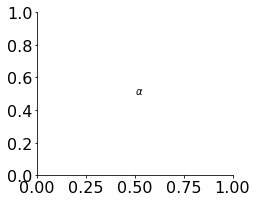

In [373]:
fig, ax = plt.subplots()
ax.text(0.5, 0.5, r"$\alpha$")